<h1 style="text-align: center; vertical-align: middle;">Reinforcement learning for focusing and steering tasks</h1>
<h2 style="text-align: center; vertical-align: middle;">Use case: ARES linear accelerator at DESY</h2>

<h3 style="text-align: center; vertical-align: middle;">Implementation example for RL4AA'23 workshop</h3>

<p style="text-align: center">Jan Kaiser, Chenran Xu, Andrea Santamaria Garcia, Simon Hirländer</p>

<h2 style="color: #b51f2a">1. ARES (Accelerator Research Experiment at SINBAD)</h2>
ARES is an S-band radio frequency linac at the DESY Hamburg site equipped with a photoinjector and two independently driven traveling wave accelerating structures. The main research focus is the generation and characterization of sub-femtosecond electron bunches at relativistic particle energy. The generation of short electron bunches is of high interest for radiation generation, i.e. by free electron lasers.

<img src="img/ARES_layout.png" width="100%"/>

- **Final energy**: 100-155 MeV
- **Bunch charge**: 0.5-30 pC
- **Bunch length**: 0.2-10 fs
- **Pulse repetition rate**: 10-50 Hz

<h2 style="color: #b51f2a">2. The accelerator problem we want to solve</h2>

<h3 style="text-align: center; vertical-align: middle;">We would like to focus and center the electron beam on a diagnostic screen using corrector and quadrupole magnets</h3>

<img src="img/ares_magnets.png" width="70%"/>

<h2 style="color: #b51f2a">3. Formulating the RL problem</h2>
<h3>3.1. Refresher from the lecture: the main elements</h3>
<img src="img/rl_problem_2.png" width="70%"/>

<h2 style="color: #b51f2a">3. Formulating the RL problem</h2>
<h3>3.2. Adaptation to our study case</h3>
<img src="img/ares_rl_problem.png" width="70%"/>

<h3>3.3. Questions</h3>

Let's think about the characteristics of our problem:
    
- Is the action space discrete or continuous?
- Is it a stationary (deterministic) problem or not?

<h2 style="color: #b51f2a">Actions</h2>
<h3>In the ARES transverse tuning task we have 3 quadrupoles and 2 corrector magnets</h3>

The actions are:
- Quadrupole magnet strength $k_{1,2,3}$ \[1/m^2\]
- Corrector deflection angle $\theta_\mathrm{v, h}$ \[mrad\] (vertical and horizontal)

In our control system we can set these derived values directly according the beam energy.



$\implies$ a 5-dimensional array

<h2 style="color: #b51f2a">Observation</h2>



The `observation` for this task contains three parts:

- 
- 
- 


 - Trial observations: pixels of the screen
    - Easier ... we already have way of measuring beam, this way only 4-dim observation
    - Feautre engineering

 - parameters of fitted Gaussian + magnet kicks and strengths

<h2 style="color: #b51f2a">Goal and Reward</h2>
<img src="img/rl_problem_1.png" width="70%"/>

 - Show reward formulars (and code?)

<h2 style="color: #b51f2a">Environment</h2>

We reprensent the tuning task as an [OpenAI Gym](https://www.gymlibrary.dev/) environment, which is a standard library for RL tasks.

A custom `gym.Env` would contain the following parts:

- Initialization: setup the environment, declares the allowed `observation_space` and `action_space`.
- `reset` method: resets the environment for a new episode, returns 2-tuple `(observation, info)`.
- `step` method: takes an `action`, changes the environment to a new `state`, get new `observation`, compute the `reward`, and finally returns the 4-tuple `(observation, reward, done, info)`.
- `render` method: to visualize the environment (a video,or just some plots)

<h3>ARESEA Environment</h3>

- `reset`: In both real and simulation cases: resets the magnets to initial values. In simulation, regenerate incoming beam, (optionally) resets the magnet misalignments.
- `step`: Set magnets to new settings. Observe the beam (run a simulation or observe screen image in real-world).

<h2 style="color: #b51f2a">Agent</h2>

- SB3
- PPO / TD3
- Anotnin Raffin decision graphic
    - Decision discussion (interactive, what would be sensible choice?)

<h2 style="color: #b51f2a">4. Algorithm implementation</h2>

We list the most relevant parts of the project structure below:

- `utils/train.py` contains the gym environments and the training script
    - `ARESEA` implements the ARES Experimental Area transverse tuning task as a `gym.Env`. It contains the basic logic, such as definition of observation space, action space, and reward. How an action is taken is implemented in child classes with specific backends. 
    - `ARESEACheetah` is derived from the base class `ARESEA`, where it uses `cheetah` simulation as a backend.
    - `make_env` Initializes a `ARESEA` envrionment, and wraps it with required [gym.wrappers](https://www.gymlibrary.dev/api/wrappers/) with convenient features (e.g. monitoring the progress, end episode when time_limit is reached, rescales the action, normalize the observation, ...)
    - `train` convenient function for training the RL agent. It calls `make_env`, setup the RL algorithm, starts training, and saves the results in `utils/recordings`, `utils/monitors` and `utils/models`.
- `utils/helpers.py` contains some utility functions
    - `evaluate_ares_ea_agent` Takes a trained agent
    

In [1]:
from time import sleep

import names
import numpy as np
from stable_baselines3 import PPO

from utils.train import train as train_ares_ea
from utils.train import make_env, read_from_yaml
from utils.helpers import (
    evaluate_ares_ea_agent,
    make_ares_ea_training_videos,
    plot_ares_ea_training_history,
    show_video,
)
from utils.utils import NotVecNormalize


Training a good agent revolves primarily around finding the right setup for the environment and the correct reward function. In order to iterate over and compare many different options, our training function takes a dictionary such as the one below.

Feel free to change things and see how they might affect the final agents.

**Note:** Traing can take a while. The actual function call is therefore commented out and we provide data from a training that we have prepared earlier.

### 📝 Notes on models
Probably remove these notes later.

Reward episodic design

 - **Suicidal (bad abort)** -> *Gary Buchwald*
    - **`"abort_if_off_screen": True`**
    - **`"reward_mode": "objective_improvement"`**
    - `"target_sigma_x_threshold": None`
    - `"target_sigma_y_threshold": None`
    - **`"time_reward": -1.0`**
    - `"action_mode": "delta"`
- **"Undetermined" towards target** -> *Betty Gordon* ... but there has been good one
    - `"abort_if_off_screen": False`
    - **`"reward_mode": "objective_improvement"`**
    - `"target_sigma_x_threshold": None`
    - `"target_sigma_y_threshold": None`
    - `"time_reward": -0.0`
    - `"action_mode": "delta"`
- **Good direct towards target** -> *Sean Kelley* ... not that much better than Betty
    - `"abort_if_off_screen": False`
    - `"reward_mode": "negative_objective"`
    - `"target_sigma_x_threshold": None`
    - `"target_sigma_y_threshold": None`
    - `"time_reward": -0.0`
    - `"action_mode": "delta"`
- **Suicidal (reward does not mean what you thought)** -> *David Archibald*
    - `"abort_if_off_screen": False`
    - **`"reward_mode": "sum_of_pixels"`**
    - `"target_sigma_x_threshold": None`
    - `"target_sigma_y_threshold": None`
    - `"time_reward": -0.0`
    - `"action_mode": "delta"`
- **Takes forever to train and fails in the real word** -> *Bertha Sparkman*
    - `"abort_if_off_screen": False`
    - **`"reward_mode": "objective_improvement"`**
    - `"target_sigma_x_threshold": None`
    - `"target_sigma_y_threshold": None`
    - `"time_reward": -0.0`
    - **`"action_mode": "direct"`**

### Configurations

In the following, we use a config dictionary to set up the training. This allows us to easily switch between different training conditions. Below we show some selected configurations that have the most influence on training results, the parameters can mostly be divided into two parts.

__1. Environment configurations__
- `abort_if_off_screen` If this property is set to True, episodes are aborted when the beam is no longer on the screen.
- `action_mode` Set directly the magnet strength or set a delta action. You may set this to `"direct"` or `"delta"`. You should find that "delta" trains faster. Setting "delta" is also crucial in running the agent on the real accelerator.
- `reward_mode`: How the reward is calculated. Can be set to "feedback" for punishment proportional to distance to target beam (r = negative objective), or set to "delta" for reward based on improvement of the distance to the target beam (r = previous objective - current objective).
- `rescale_action`: Takes the limits of the magnet settings and scale them into the following range.
- `time_limit`: Number of interactions the agent gets to tune the magnets within one episode.
- `time_reward`: Whether the agent will be penalized for making another step, this is intended to make the tuning faster.
- `target_sigma_x_threshold`, `target_sigma_y_threshold`: Thresholds for beam parameters. If all beam parameters are within the threshold from their target, episodes will end and the agent will stop optimising.

__2. Training configurations__
- `gamma`: Discount factor of the RL problem. Set lower to make rewards now more important than rewards later (usually above 0.9)
- `batch_size`: Batch size of the neural network training in the PPO algorithm
- `normalize_observation`: Normalise observations throughout training by fitting a running mean and standard deviation of them.
- `normalize_reward`: Normalise rewards throughout training by fitting a running mean and standard deviation of them.
- `total_timesteps`: Number of interactions with the environment that the agent is allowed to traing for.

<h2 style="color: #b51f2a">What could go wrong?</h2>



In [3]:
# TODO insert cell to change agent name from current to pre-trained

In [2]:
# Feel free to change some of the configurations here.
config = {
    "abort_if_off_screen": False,
    "action_mode": "delta",
    "batch_size": 100,
    "gamma": 0.99,
    # TODO Maybe include network architecture (could also speed up training)
    "frame_stack": None,
    "normalize_observation": True,
    "normalize_reward": True,
    "rescale_action": (-3, 3),
    "reward_mode": "negative_objective",
    "run_name": names.get_full_name(),
    "target_sigma_x_threshold": None,
    "target_sigma_y_threshold": None,
    "total_timesteps": 300_000,
    "threshold_hold": 5,
    "time_limit": 25,
    "time_reward": -0.0,
}

# Toggle comment to re-run the training (can take very long)
train_ares_ea(config)


==> Training agent "Frederick Silsby"
Eval num_timesteps=20000, episode_reward=-11.57 +/- 1.23
Episode length: 25.00 +/- 0.00
New best mean reward!
Eval num_timesteps=40000, episode_reward=-7.57 +/- 1.15
Episode length: 25.00 +/- 0.00
New best mean reward!
Eval num_timesteps=60000, episode_reward=-6.27 +/- 1.67
Episode length: 25.00 +/- 0.00
New best mean reward!
Eval num_timesteps=80000, episode_reward=-4.39 +/- 0.97
Episode length: 25.00 +/- 0.00
New best mean reward!
Eval num_timesteps=100000, episode_reward=-4.28 +/- 1.67
Episode length: 25.00 +/- 0.00
New best mean reward!
Eval num_timesteps=120000, episode_reward=-6.78 +/- 3.16
Episode length: 25.00 +/- 0.00
Eval num_timesteps=140000, episode_reward=-3.79 +/- 0.75
Episode length: 25.00 +/- 0.00
New best mean reward!
Eval num_timesteps=160000, episode_reward=-3.91 +/- 0.70
Episode length: 25.00 +/- 0.00
Eval num_timesteps=180000, episode_reward=-5.04 +/- 1.88
Episode length: 25.00 +/- 0.00
Eval num_timesteps=200000, episode_reward

As before we can look at the training metrics and check out videos taken at different stages of the training ...

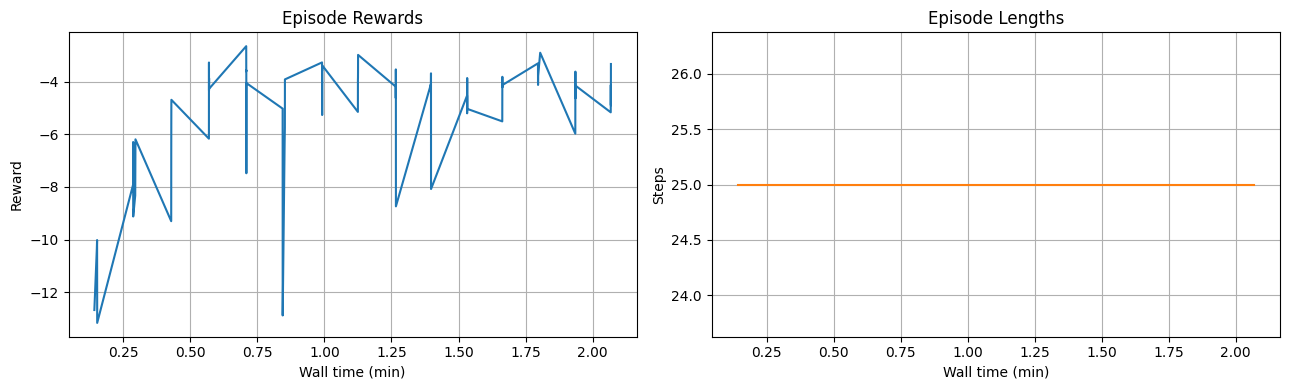

In [4]:
# Training curves from this training
# Change `config["run_name"` to `"ml_worksop` to see curves from example training.
plot_ares_ea_training_history(config["run_name"])


To look at videos of the agent during training, find the first output line of the training cell. Your agent should have a name (e.g. *Fred Rogers*). Find the subdirectory `utils/recordings/`. There should be a directory for the name of your agent with video files in it. The `ml_workshop` directory contains videos from an example training.

Run the following cell to evaluate your agent. This is the mean deviation of the beam parameters from the target. Lower results are better.

If you are training agents that include the dipoles, set the functions argument `include_position=True`.

In [5]:
evaluate_ares_ea_agent(config["run_name"], include_position=False, n=2000)
# TODO (RMSE / steps to convergence / over time plots) -> also just consider size not position


==> Achieved a score of 4.3522213525790224e-05 (2000 evaluations)


We can also test the trained agent on a simulation.

If you want to see an example agent instead of the one you just trained, set `agent_name="ml_workshop"`.

In [6]:
# Run final agent
agent_name = config["run_name"]

loaded_model = PPO.load(f"utils/models/{agent_name}/model")
loaded_config = read_from_yaml(f"utils/models/{agent_name}/config")

env = make_env(loaded_config, record_video=True)
env = NotVecNormalize(env, f"utils/models/{agent_name}/normalizer")

done = False
observation = env.reset()
while not done:
    action, _ = loaded_model.predict(observation)
    observation, reward, done, info = env.step(action)
env.close()


In [7]:
show_video(f"utils/recordings/{config['run_name']}/rl-video-episode-0.mp4")

### Running in the real world

Below you can see one of our final trained agents optimising position and focus of the beam on the real ARES accelerator.

Keep in mind that this agent has never seen the real accelerator before. All it has ever seen is a very simple linear beam dynamics simulation. Despite that it performs well on the real accelerator where all kinds of other effects come into the mix.

Note that this does not happen by itself and is the result of various careful decisions when designing the traiing setup.

Once trained, the agent is, however, trivial to use and requires no futher tuning or knowledge of RL.

In [8]:
# Show polished donkey running (on real accelerator)
show_video("utils/real_world_episode_recording.mp4")


## Further Resources

### Getting started in RL
 - [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/index.html) - Very understandable explainations on RL and the most popular algorithms acompanied by easy-to-read Python implementations.
 - [Reinforcement Learning with Stable Baselines 3](https://youtube.com/playlist?list=PLQVvvaa0QuDf0O2DWwLZBfJeYY-JOeZB1) - YouTube playlist giving a good introduction on RL using Stable Baselines3.
 - [Build a Doom AI Model with Python](https://youtu.be/eBCU-tqLGfQ) - Detailed 3h tutorial of applying RL using *DOOM* as an example.
 - [An introduction to Reinforcement Learning](https://youtu.be/JgvyzIkgxF0) - Brief introdution to RL.
 - [An introduction to Policy Gradient methods - Deep Reinforcement Learning](https://www.youtube.com/watch?v=5P7I-xPq8u8) - Brief introduction to PPO.

### Papers

 - [Learning-based optimisation of particle accelerators under partial observability without real-world training](https://proceedings.mlr.press/v162/kaiser22a.html) - Tuning of electron beam properties on a diagnostic screen using RL.
 - [Sample-efficient reinforcement learning for CERN accelerator control](https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.23.124801) - Beam trajectory steering using RL with a focus on sample-efficient training.
 - [Autonomous control of a particle accelerator using deep reinforcement learning](https://arxiv.org/abs/2010.08141) - Beam transport through a drift tube linac using RL.
 - [Basic reinforcement learning techniques to control the intensity of a seeded free-electron laser](https://www.mdpi.com/2079-9292/9/5/781/htm) - RL-based laser alignment and drift recovery.
 - [Real-time artificial intelligence for accelerator control: A study at the Fermilab Booster](https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.24.104601) - Regulation of a gradient magnet power supply using RL and real-time implementation of the trained agent using field-programmable gate arrays (FPGAs).
 - [Magnetic control of tokamak plasmas through deep reinforcement learning](https://www.nature.com/articles/s41586-021-04301-9) - Landmark paper on RL for controling a real-world physical system (plasma in a tokamak fusion reactor).

### Literature
 
 - [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html) - Standard text book on RL.

### Packages
 - [Gym](https://www.gymlibrary.ml) - Defacto standard for implementing custom environments. Also provides a library of RL tasks widely used for benchmarking.
 - [Stable Baslines3](https://github.com/DLR-RM/stable-baselines3) - Provides reliable, benchmarked and easy-to-use implementations of the most important RL algorithms.
 - [Ray RLlib](https://docs.ray.io/en/latest/rllib/index.html) - Part of the *Ray* Python package providing implementations of various RL algorithms with a focus on distributed training.